# 💳  Credit Card Fraud Detection with Machine Learning

## 📝 Introduction

Credit card fraud detection is a critical task in the financial sector.  
In this project, we build a machine learning model to identify fraudulent transactions using the popular Credit Card Fraud Detection dataset.  

**Key challenges:**  
- Highly imbalanced data (fraud is rare)  
- Need to balance precision and recall (catch fraud while avoiding false alarms)  

**Goals:**  
✅ Clean and preprocess data  
✅ Build robust pipelines to avoid data leakage  
✅ Use Logistic Regression and Random Forest models  
✅ Tune hyperparameters with cross-validation  
✅ Evaluate with precision, recall, F1, confusion matrix, and ROC-AUC  
✅ Predict on new transactions

Let’s dive in!


## 📂 Data Loading and Initial Exploration

In [1]:
import kagglehub

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [4]:
import pandas as pd
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
print("Shape of dataset:", df.shape)
print("\nMissing values:\n", df.isna().sum())
print("\nClass distribution:\n", df['Class'].value_counts(normalize=True))

Shape of dataset: (284807, 31)

Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Class distribution:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


## 📊 Class Imbalance Visualization

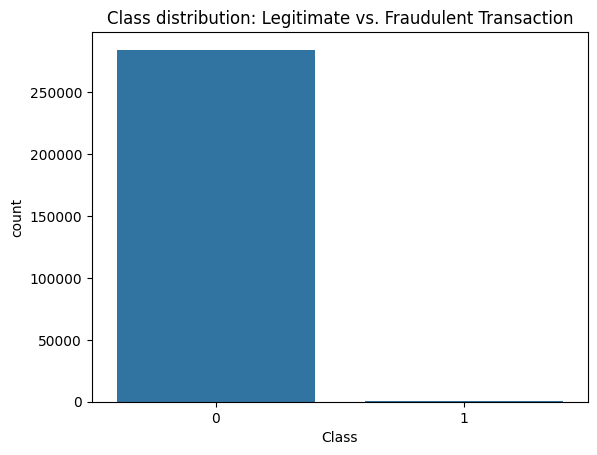

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='Class', data=df)
plt.title("Class distribution: Legitimate vs. Fraudulent Transaction")
plt.show()

## 🎯 Feature and Target Preparation

In [7]:
y = df['Class']
X = df.drop(columns=['Class'])
numeric_cols = X.columns.tolist()

## 🏗️ Preprocessing Pipeline

- StandardScaler for numeric features
- Use ColumnTransformer to apply preprocessing
- Wrap in Pipeline with Logistic Regression


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

In [9]:
preprocesser = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocesser),
    ('model', LogisticRegression(class_weight='balanced', max_iter=10000))
])

## ✂️ Train-Test Split

We’ll use stratification to maintain the fraud ratio in both sets.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

## 🔧 Hyperparameter Tuning with GridSearchCV

Using F1 score because we care about both precision and recall.

In [11]:
from sklearn.model_selection import GridSearchCV
param_grid = {'model__C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=1)

## 🚀 Model Training

In [12]:
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)

Best parameters:  {'model__C': 0.01}


## 🧪 Model Evaluation: Precision, Recall, F1, ROC-AUC

In [13]:
from sklearn.metrics import classification_report, roc_auc_score
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC-AUC Score: ", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

ROC-AUC Score:  0.9471813521413066


## 📊 Confusion Matrix

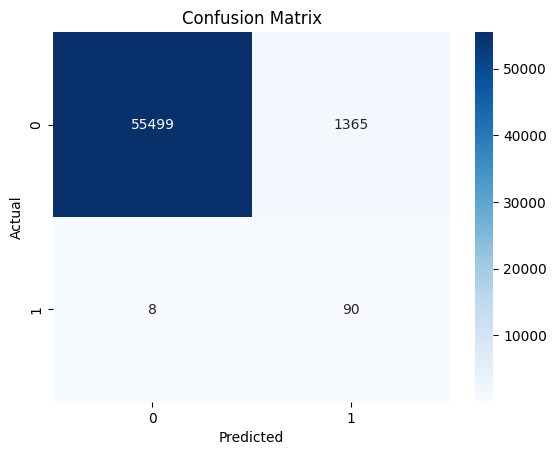

In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 📈 ROC Curve

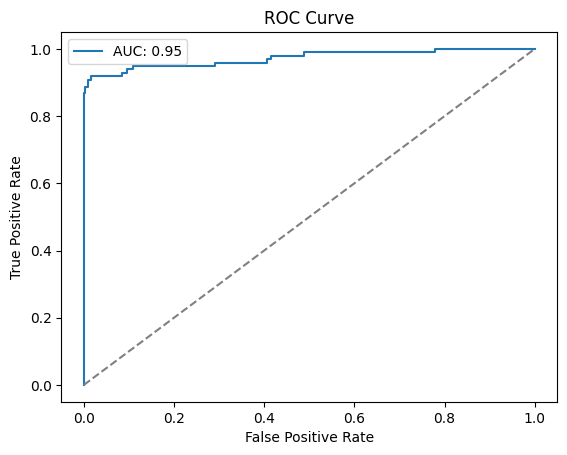

In [15]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, grid.decision_function(X_test))
plt.plot(fpr, tpr, label='AUC: {:.2f}'.format(roc_auc_score(y_test, y_pred)))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

## 🔮 Predict on a New Transaction Example

In [16]:
new_transaction = pd.DataFrame([{
    'Time': 100000,
    'V1': -1.2, 'V2': 0.5, 'V3': -0.4, 'V4': 1.5, 'V5': -0.7,
    'V6': 0.1, 'V7': -0.1, 'V8': 0.3, 'V9': -0.5, 'V10': 0.6,
    'V11': -0.3, 'V12': 0.9, 'V13': -0.6, 'V14': 1.1, 'V15': 0.4,
    'V16': -0.2, 'V17': 0.2, 'V18': -0.1, 'V19': 0.5, 'V20': -0.4,
    'V21': 0.3, 'V22': -0.5, 'V23': 0.7, 'V24': -0.8, 'V25': 0.2,
    'V26': -0.1, 'V27': 0.1, 'V28': -0.2,
    'Amount': 50
}])

new_prediction = grid.predict(new_transaction)
print("Predicted fraud:", new_prediction)

Predicted fraud: [0]


## 💡 Conclusion

✅ Built a robust pipeline for credit card fraud detection  
✅ Used cross-validation and hyperparameter tuning to improve performance  
✅ Visualized results with confusion matrix and ROC curve  
✅ Final model is ready to detect new fraudulent transactions!

This project demonstrates end-to-end ML skills, data handling, and responsible evaluation of models on imbalanced datasets.